# MLT HW 1

Performed by Matveev Nikita

In this notebook, I combined tasks 1, 2, and 3 into a single function and ran it for every type of estimator. 
For Part 4, I chose the most robust classifier. By setting a new threshold, I achieved the expected recall level.

Additionally, I performed some feature selection)


In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

In [2]:

# Set random seed for NumPy for data splitting
np.random.seed(42)

# Set random seed for random module
random.seed(42)

#### Read data

In [3]:
df = pd.read_csv('./bioresponse.csv')

In [4]:
df.shape

(3751, 1777)

In [5]:
X = df.drop(columns = 'Activity')
y = df.Activity

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75)

### Features preprocessing
Given dataset has too many featrues, i want to filter it a bit

In [7]:
uniq_values = X_train.nunique()
zero_values = (X_train == 0).sum(0)

We have many features with low count of unique values

<Axes: >

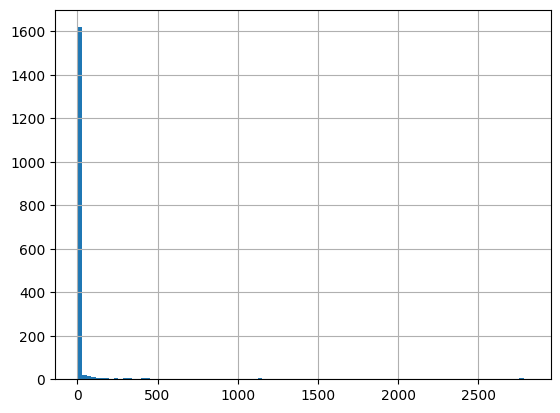

In [8]:
uniq_values.hist(bins=100)

In [9]:
constant = uniq_values[uniq_values == 1].index.tolist()
binary = uniq_values[uniq_values == 2].index.tolist()
categorical = uniq_values[uniq_values <= 10].index.tolist()

Calculate features with low variance (it's important to exclude categorical variables from thresholding)

<Axes: >

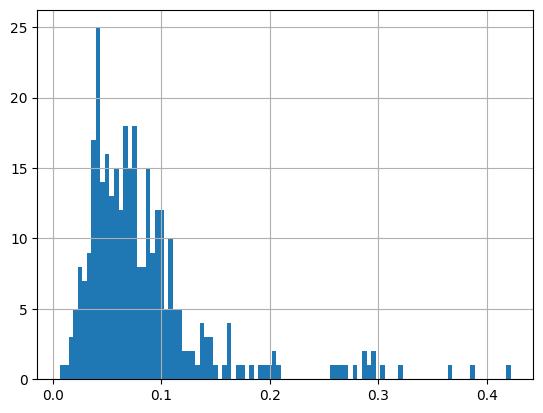

In [10]:
X_train[[col for col in X_train.columns if col not in categorical]].std().hist(bins=100)

In [11]:
variance_threshold = 0.1
selector = VarianceThreshold(threshold=variance_threshold)
X_high_variance = selector.fit_transform(X)
low_variance_feats = set(X.columns[~selector.get_support()].tolist()) - set(categorical) # here using ~ to get features that weren't selected

### Find highly correlated features

In [12]:
correlation_matrix = X_train.corr().abs()
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
correlated_pairs = [(i, j) for i in range(len(correlation_matrix.columns)) for j in range(i + 1, len(correlation_matrix.columns)) if correlation_matrix.iloc[i, j] > 0.8]


### Drop

In [13]:
to_drop = []
to_drop += constant
# to_drop += low_variance_feats
for p in correlated_pairs:
    to_drop.append(X_train.columns[p[1]])

In [14]:
X_train_filt = X_train.drop(columns=set(to_drop))
X_val_filt = X_val.drop(columns=set(to_drop))

# Part 1,2 and 3: Fitting and evaluating models

I created union function to perform models fitting and evaluations

In [15]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    log_l = log_loss(y_val, y_proba)
    # Create subplots with two axes in one row
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

    # Print metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Roc Auc score:", roc_auc)
    print("Log loss:", log_l)
    # Plot precision-recall curve on the first axis
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ax1.plot(recall, precision, color='blue', lw=2)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curve')
    ax1.grid(True)

    # Plot ROC curve on the second axis
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ax2.plot(fpr, tpr, color='red', lw=2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate (Recall)')
    ax2.set_title('ROC Curve')
    ax2.grid(True)

    # Adjust the layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

    return model

Let's at first try to fit models on full subset of features

Precision: 0.779783393501805
Recall: 0.8074766355140187
Accuracy: 0.7601279317697228
F1 Score: 0.7933884297520661
Roc Auc score: 0.7510679251408826
Log loss: 0.7432328648241397


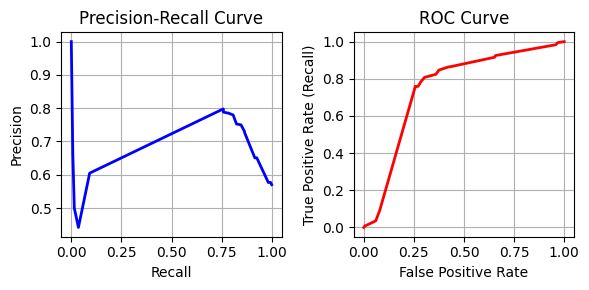

DecisionTreeClassifier(max_depth=5)

In [16]:
evaluate_model(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_val, y_val)

Precision: 0.7673545966228893
Recall: 0.7644859813084112
Accuracy: 0.7334754797441365
F1 Score: 0.7659176029962546
Roc Auc score: 0.6730618492149996
Log loss: 6.640190524896234


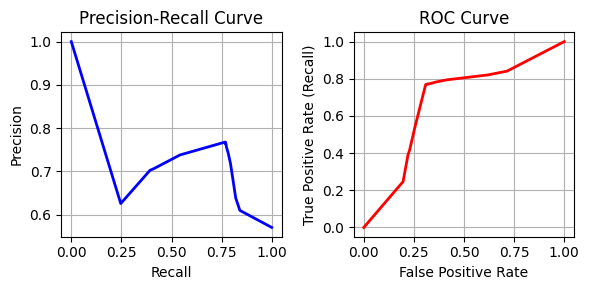

DecisionTreeClassifier(max_depth=15)

In [17]:
evaluate_model(DecisionTreeClassifier(max_depth=15), X_train, y_train, X_val, y_val)

Precision: 0.7977099236641222
Recall: 0.7813084112149533
Accuracy: 0.7622601279317697
F1 Score: 0.7894239848914069
Roc Auc score: 0.8352079033417592
Log loss: 0.5435093352530522


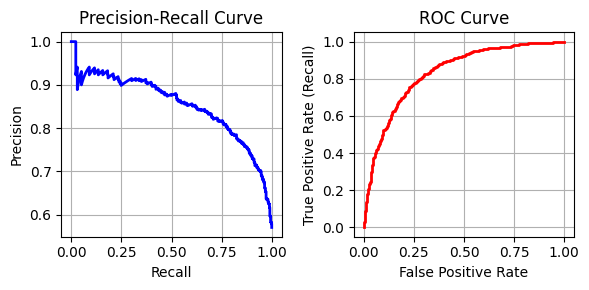

RandomForestClassifier(max_depth=5)

In [18]:
evaluate_model(RandomForestClassifier(n_estimators=100, max_depth=5), X_train, y_train, X_val, y_val)

Precision: 0.8166666666666667
Recall: 0.8242990654205608
Accuracy: 0.7942430703624733
F1 Score: 0.8204651162790698
Roc Auc score: 0.8714547436283946
Log loss: 0.46320652205912827


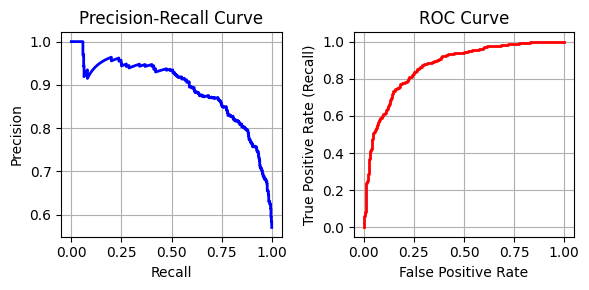

RandomForestClassifier(max_depth=15)

In [19]:
evaluate_model(RandomForestClassifier(n_estimators=100, max_depth=15), X_train, y_train, X_val, y_val)

As we can see, filtering features don't drop accuracy of classifier much, but speed up training

Precision: 0.8230912476722533
Recall: 0.8261682242990654
Accuracy: 0.7995735607675906
F1 Score: 0.8246268656716418
Roc Auc score: 0.8734282600125228
Log loss: 0.4655835465250175


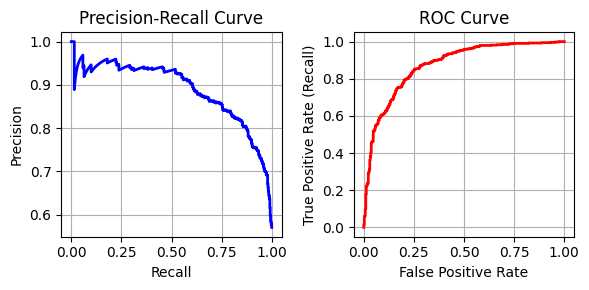

In [20]:
estimator = evaluate_model(RandomForestClassifier(n_estimators=100, max_depth=15), X_train_filt, y_train, X_val_filt, y_val)

Also we can use only important features from fitted estimator and speed up training more for further experiments (very important step for model hyperparameters optimisation)

In [21]:
importances = pd.Series(estimator.feature_importances_, index=X_train_filt.columns)
selected = abs(importances).sort_values().tail(100).index.tolist()

Precision: 0.8245283018867925
Recall: 0.8168224299065421
Accuracy: 0.7963752665245203
F1 Score: 0.8206572769953052
Roc Auc score: 0.8708332367060133
Log loss: 0.45701946921365383


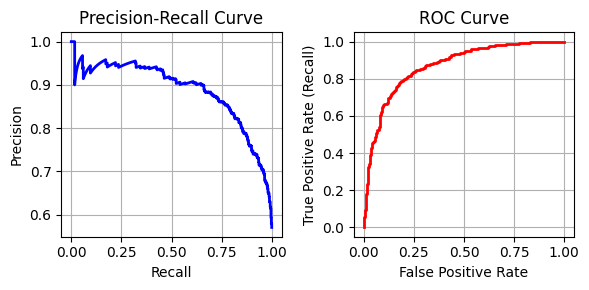

In [22]:
estimator = evaluate_model(RandomForestClassifier(n_estimators=100, max_depth=15), X_train_filt[selected], y_train, X_val_filt[selected], y_val)

### Part 4. High-recall estimator

Precision: 0.6739974126778784
Recall: 0.9738317757009346
Accuracy: 0.7164179104477612
F1 Score: 0.7966360856269113
Roc Auc score: 0.8743953062313027
Log Loss: 0.4543711979183358


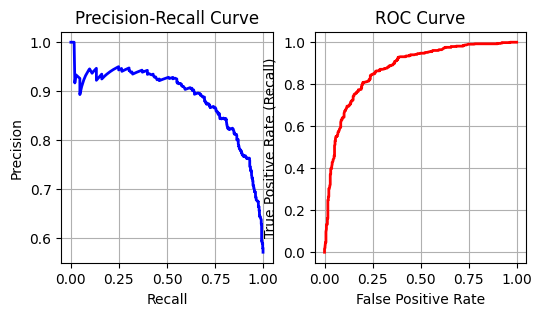

In [23]:
model = RandomForestClassifier(n_estimators=100, max_depth=50, max_features='sqrt', criterion='entropy', min_samples_split=3)
model.fit(X_train_filt[selected], y_train)
thr = 0.25

y_proba = model.predict_proba(X_val_filt[selected])[:, 1]
y_pred = (y_proba > thr).astype(int)
# Calculate metrics
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)
log_l = log_loss(y_val, y_proba)
# Create subplots with two axes in one row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Roc Auc score:", roc_auc)
print("Log Loss:", log_l)
# Plot precision-recall curve on the first axis
precision, recall, _ = precision_recall_curve(y_val, y_proba)
ax1.plot(recall, precision, color='blue', lw=2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.grid(True)

# Plot ROC curve on the second axis
fpr, tpr, _ = roc_curve(y_val, y_proba)
ax2.plot(fpr, tpr, color='red', lw=2)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate (Recall)')
ax2.set_title('ROC Curve')
ax2.grid(True)

Here we got very high recall estimator and btw accuracy is not too low! 